## imports

In [1]:
from cloud_dataset import CloudDataset
from losses import intersection_over_union
import pandas as pd
import matplotlib.pyplot as plt
import xrspatial.multispectral as ms
import torch
import rioxarray
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import numpy as np
import torch.optim as optim
import multiprocessing
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
from PIL import Image as im
from tqdm.notebook import tqdm_notebook
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import segmentation_models_pytorch as smp

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Loading and HyperParameters

In [3]:
BANDS = ["B02", "B03", "B04", "B08"]

In [4]:
train_x = pd.read_csv("data/train_x.csv").drop(columns = "Unnamed: 0")
train_y = pd.read_csv("data/train_y.csv").drop(columns = "Unnamed: 0")  
val_x = pd.read_csv("data/val_x.csv").drop(columns = "Unnamed: 0")    
val_y = pd.read_csv("data/val_y.csv").drop(columns = "Unnamed: 0")

In [5]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_SIZE = 512
CHANNELS_IMG = 4
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 50
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

# both_transform = A.Compose(
#     [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
# )

train_transforms = A.Compose(
        [
            A.Rotate(limit=60, p=0.6),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
    [
        ToTensorV2(),
    ]
)

In [6]:
trainset = CloudDataset(train_x, BANDS, train_y, train_transforms, norm = True)
valset = CloudDataset(val_x, BANDS, val_y, val_transforms, norm = True)

In [7]:
chk = trainset[423]

In [8]:
# plt.imshow(chk["chip"][0, :, :])

In [9]:
# plt.imshow(chk["label"][:, :])

In [10]:
train_loader = DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(dataset = valset, batch_size = 32, shuffle = False, pin_memory=True, num_workers=4)

## Discriminator

In [11]:
import torch
import torch.nn as nn


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels = 4, features = [64, 128, 256, 512]) -> None: # 256 -> 30 x 30
        super().__init__()
        
        self.initial = nn.Sequential(
        
            nn.Conv2d(in_channels + 1, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        
        layers = []
        in_channels = features[0]
        
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride = 1 if feature == features[-1] else 2),
            )
            in_channels = feature
        
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride = 1, padding = 1, padding_mode='reflect'
            )
        )
        
        self.model = nn.Sequential(*layers)
        
        # print(type(*layers), layers)
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim = 1)
        x = self.initial(x)
        return self.model(x)
    
def test():
    x = torch.randn((16,4,512,512))
    y = torch.randn((16,1,512,512))
    model = Discriminator()
    preds = model(x,y)
    print(preds.shape)
    # print(model)

# if __name__ == "__main__":
#     test()

## Generator

In [12]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.bottleneck = nn.Sequential(nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU())

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False)
        
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)
        
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)
        
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        self.final_up = nn.Sequential(nn.ConvTranspose2d(features * 2, 1, kernel_size=4, stride=2, padding=1), nn.Tanh())

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


def test():
    x = torch.randn((16, 4, 512, 512))
    model = Generator(in_channels=4, features=64)
    preds = model(x)
    print(preds.shape)
    # print(model)

# if __name__ == "__main__":
#     test()

## Utils

In [13]:
# def save_some_examples(gen, val_loader, epoch, folder):
#     x, y = next(iter(val_loader))
#     x, y = x.to(config.DEVICE), y.to(config.DEVICE)
#     gen.eval()
#     with torch.no_grad():
#         y_fake = gen(x)
#         y_fake = y_fake * 0.5 + 0.5  # remove normalization#
#         save_image(y_fake, folder + f"/y_gen_{epoch}.png")
#         save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
#         if epoch == 1:
#             save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
#     gen.train()


# def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
#     print("=> Saving checkpoint")
#     checkpoint = {
#         "state_dict": model.state_dict(),
#         "optimizer": optimizer.state_dict(),
#     }
#     torch.save(checkpoint, filename)


# def load_checkpoint(checkpoint_file, model, optimizer, lr):
#     print("=> Loading checkpoint")
#     checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
#     model.load_state_dict(checkpoint["state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer"])

#     # If we don't do this then it will just have learning rate of old checkpoint
#     # and it will lead to many hours of debugging \:
#     for param_group in optimizer.param_groups:
#         param_group["lr"] = lr



## Training Function

In [14]:
torch.backends.cudnn.benchmark = True

def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
    loop = tqdm_notebook(loader, leave=True)
    idx = 0

    for it in loop:
        x = it["chip"]
        y = it["label"].unsqueeze(1)
        x = x.to(device)
        y = y.to(device)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )
        idx+=1

In [15]:
disc = Discriminator(in_channels=4).to(device)
gen = Generator(in_channels=4, features=64).to(device)
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

In [16]:
gen.load_state_dict(torch.load("genPIX_trained_weights.pt"))
disc.load_state_dict(torch.load("discPIX_trained_weights.pt"))

<All keys matched successfully>

In [17]:
# f= open("num_epochs_out.txt","w+")
# f.write(f"{device}\n" )

In [18]:
# g_scaler = torch.cuda.amp.GradScaler()
# d_scaler = torch.cuda.amp.GradScaler()

# for i, epoch in enumerate(range(NUM_EPOCHS)):
#     train_fn(
#         disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
#     )
#     torch.save(disc.state_dict(), f"discPIX_trained_weights.pt" )   
#     torch.save(gen.state_dict(), f"genPIX_trained_weights.pt" )
#     # f.write(f"{i}th epoch done\n")

In [19]:
print("ok")

ok


## Ensemble

In [20]:
# dlab = smp.DeepLabV3Plus(
#     encoder_name="resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="ssl",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=2,                      # model output channels (number of classes in your dataset)
# ).to(device)

In [21]:
# dlab.load_state_dict(torch.load("plus19thplus_epoch_trained_weights.pt"))

## Validation

In [22]:
vex = next(iter(val_loader))

In [23]:
chk = vex["chip"].to(device)

In [24]:
outgen = gen(chk).squeeze()

In [25]:
# torch.cuda.empty_cache()

In [26]:
# outdlab = dlab(chk)

In [27]:
# outdlab = outdlab.argmax(1)

In [28]:
# outgen = outgen.squeeze()>0.5

In [29]:
# out = (outdlab+outgen)/2

In [30]:
outgen = (outgen) > 0.5

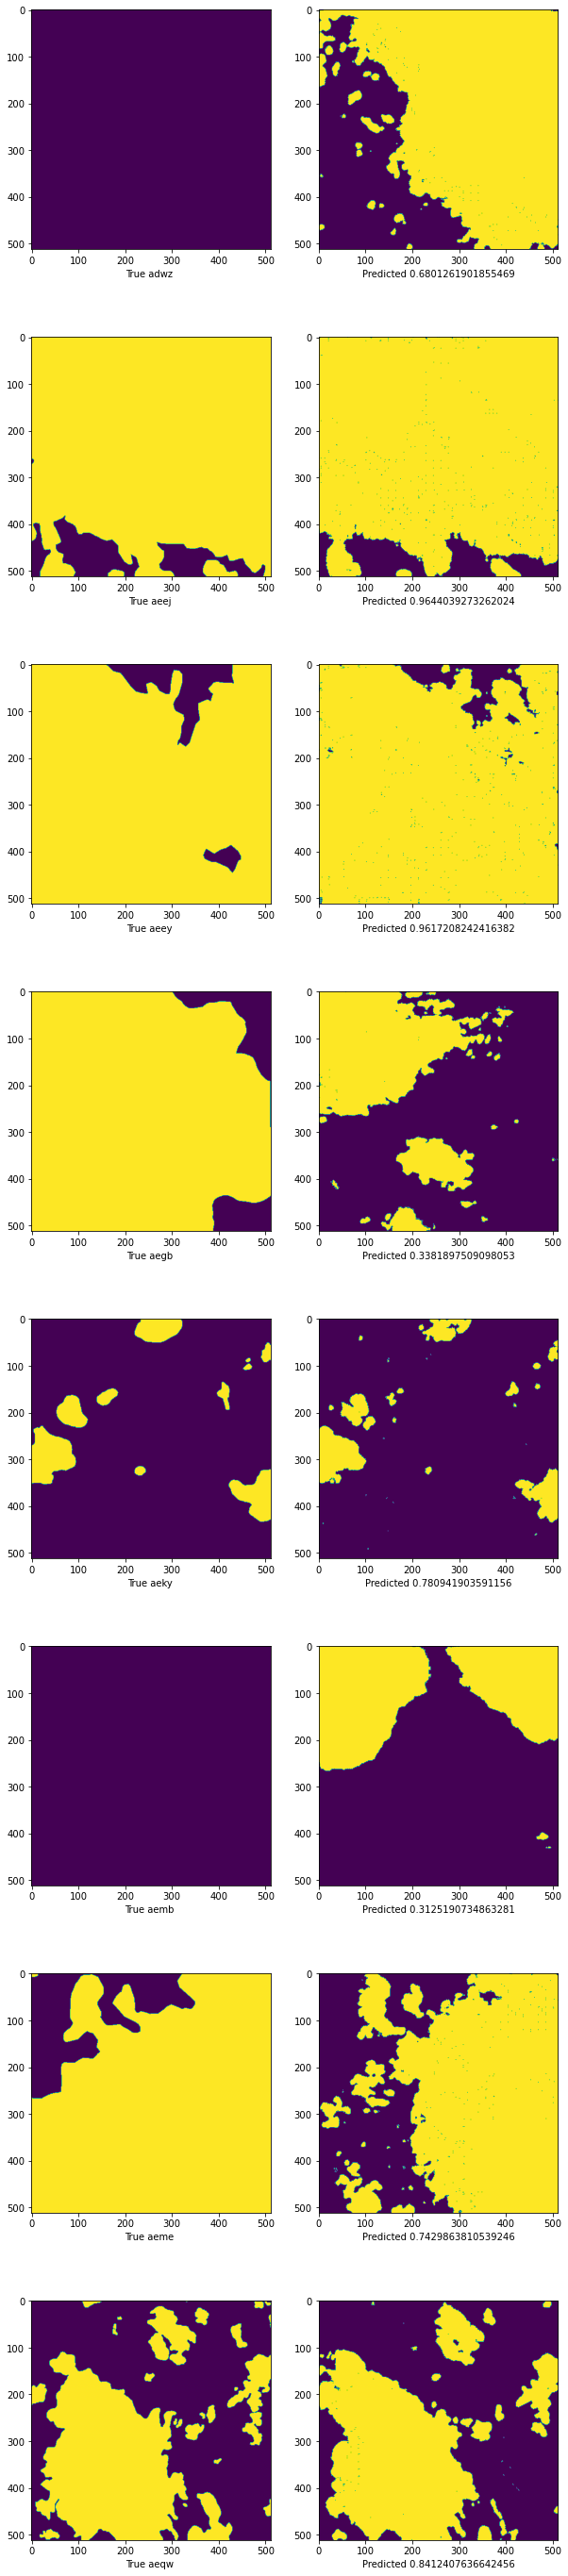

In [31]:
fig, ax = plt.subplots(8, 2, figsize = (10, 50))
for i in range(8):
    pred = (outgen[i, :, :].to("cpu").detach())
    true = (vex["label"][i, :, :].squeeze())
    id = vex["chip_id"][i]
    ax[i][0].imshow(true)
    ax[i][1].imshow(pred)
    ax[i][0].set_xlabel(f"True {id} ")
    ax[i][1].set_xlabel(f"Predicted {intersection_over_union(pred, true)}")

In [32]:
# plt.imshow(true)
# print(vex["chip_id"][ind])

In [33]:
gen.eval()
ioulis = []
loadtq  = tqdm_notebook(val_loader)

with torch.no_grad():
    for it in loadtq:
        inpic = it["chip"].to(device).type(torch.cuda.FloatTensor)
        true = it["label"].squeeze()
        pred = (gen(inpic) > 0.5)
        predic = pred.squeeze()
        iou = intersection_over_union(predic.detach().to("cpu"), true.detach().to("cpu"))
        ioulis.append(iou)
        loadtq.set_postfix(iou = iou)
    
# # model.train()

  0%|          | 0/122 [00:00<?, ?it/s]

In [34]:
ioulis = torch.tensor(ioulis)

In [35]:
# gen.eval()
# ioulis = []
# loadtq  = tqdm_notebook(val_loader)

# with torch.no_grad():
#     for it in loadtq:
#         inpic = it["chip"].to(device)
#         true = it["label"].squeeze()
#         outgen = gen(inpic)
#         # outdlab = dlab(inpic)
#         # outdlab = outdlab.argmax(1)
#         outgen = (outgen.squeeze()>0.5)
#         # out = (outdlab+outgen)/2
#         iou = intersection_over_union(outgen.detach().to("cpu"), true.detach().to("cpu"))
#         ioulis.append(iou)
#         loadtq.set_postfix(iou = iou)
    
# # model.train()

In [36]:
# ioulis = np.array(ioulis)

In [37]:
ioulis.mean()

tensor(0.8114)

In [38]:
torch.save(gen, "Generator.pt")

In [39]:
model = torch.load("Generator.pt")

In [ ]:
# bad = np.where(ioulis <= 0.9)

In [ ]:
# bad[0].shape

In [ ]:
# ioulis.shape